# Wildfires

# Preprocessing

In [59]:
import pandas as pd

fire = pd.read_csv("fire_df_08_01.csv")
wind = pd.read_csv("wind_df_08_01.csv")

for df in [fire, wind]:
    df['datetime'] = df['datetime'].apply(lambda time: pd.to_datetime(time).replace(second=0, microsecond=0))
    df[['longitude', 'latitude']] = df[['longitude', 'latitude']].round(5)

merge = pd.merge(fire, wind, how="outer", on=["datetime", "longitude", "latitude"])
merge.to_csv("merge.csv", index=False)

In [60]:
import pandas as pd

fire = pd.read_csv("fire_df_08_01.csv")
wind = pd.read_csv("wind_df_08_01.csv")

for df in [fire, wind]:
    df['datetime'] = df['datetime'].apply(lambda time: pd.to_datetime(time).replace(second=0, microsecond=0))
    df[['longitude', 'latitude']] = df[['longitude', 'latitude']].round(5)

merge = pd.merge_ordered(fire, wind, how="left", on=['datetime', 'longitude', 'latitude'], fill_method='ffill')
merge.to_csv("merge.csv", index=False)

# Format data

In [61]:
from sklearn.preprocessing import normalize
import numpy as np

def process_fire(row):
    return np.array(np.nan_to_num(row))

merge = pd.read_csv("merge.csv")
merge = merge.sort_values(['longitude', 'latitude'])
grouped = merge.groupby('datetime')

wind = grouped['speed'].apply(np.array).to_list()
fire = np.array(grouped['Power'].apply(process_fire).to_list())
fire = normalize(fire)

# Define and train model

In [62]:
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(features).float()
        self.labels = torch.from_numpy(labels).float()
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [68]:
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_loss = []
    test_loss = []
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        test_loss.append(test(model, criterion, test_loader))
        
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        train_loss.append(total_loss)

        # Print the average loss for this epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}')
        
    return train_loss, test_loss


def test(model: MLP, criterion, dl):
    model.eval()
    total_loss = 0
    for i, (inputs, labels) in enumerate(dl):
        predicted = model(inputs)
        loss = criterion(predicted, labels)
        total_loss += loss.item()
        
    return total_loss

(144, 6160)
Epoch [1/10], Loss: 0.055570986714552746
Epoch [2/10], Loss: 0.03483173335817727
Epoch [3/10], Loss: 0.02437980684705756
Epoch [4/10], Loss: 0.01798832331868735
Epoch [5/10], Loss: 0.013659565963528374
Epoch [6/10], Loss: 0.011200239035216246
Epoch [7/10], Loss: 0.009262935766442255
Epoch [8/10], Loss: 0.0076526050371202555
Epoch [9/10], Loss: 0.006619273938915946
Epoch [10/10], Loss: 0.005771556128324432


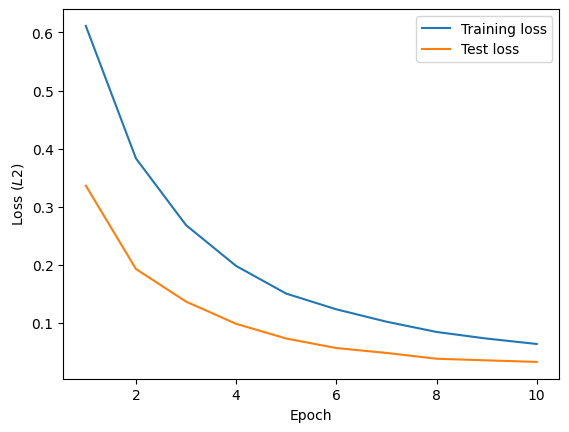

In [69]:
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

data = np.hstack((fire, wind))
print("Data shape:", data.shape)

train_x, test_x, train_y, test_y = train_test_split(data[:-1], fire[1:])
train_dl = DataLoader(CustomDataset(train_x, train_y), batch_size=10, shuffle=True)
test_dl = DataLoader(CustomDataset(test_x, test_y), batch_size=10, shuffle=True)

epochs = 10
loss_func = nn.MSELoss()
mlp = MLP(data.shape[1], 5000, data.shape[1] // 2)
train_loss, test_loss = train(mlp, train_dl, test_dl, loss_func, optim.SGD(mlp.parameters(), lr=0.01), epochs)
from matplotlib import pyplot as plt

def plot_loss(train_loss, test_loss):
    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training loss")
    plt.plot(range(1, len(test_loss) + 1), test_loss, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss ($L2$)")
    plt.legend()
    plt.show()
    
plot_loss(train_loss, test_loss)